In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

dataset_path = "/content/drive/My Drive/Colab"  # Путь к папке

print("Содержимое папки:")
print(os.listdir(dataset_path))


Содержимое папки:
['test', 'train', 'valid']


In [ ]:
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")
test_path = os.path.join(dataset_path, "test")

print("Train set:", os.listdir(train_path)[:5])  # Проверка первых 5 файлов


Train set: ['image_1144_png.rf.2cb363a0330e5b5d68b2306831ee55bf.jpg', 'image_1214_png.rf.99e79a55dc998a34aebabc039f7476bd.jpg', 'image_1251_png.rf.0c3cb7b04ca85ff2b8117329cc8c6239.jpg', 'image_1291_png.rf.5d8bdbb212106560080d8d7a57b3cb8d.jpg', 'image_1276_png.rf.0c4abf37f7019f9f08ef9700c28d0611.jpg']


In [ ]:
annotation_file = os.path.join(train_path, "_annotations.coco.json")


In [ ]:
from google.colab import drive

# Подключаем Google Drive
drive.mount('/content/drive')

# Установка нужных библиотек
!pip install -q torch torchvision torchaudio opencv-python matplotlib pycocotools albumentations


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.1 MB/s eta 0:00:00


In [ ]:
import os
import json
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Пути к данным в Google Drive
DATASET_PATH = "/content/drive/My Drive/Colab"  # Убедись, что это верный путь
IMAGE_PATH = os.path.join(DATASET_PATH, "train")  # Или "valid", "test"
ANNOTATION_FILE = os.path.join(IMAGE_PATH, "_annotations.coco.json")  # Убедись, что файл существует

# Загружаем COCO-аннотации
coco = COCO(ANNOTATION_FILE)
img_ids = coco.getImgIds()
cat_ids = coco.getCatIds()

# Функция для конвертации COCO-аннотаций в бинарные маски
def coco_to_mask(image_id, coco):
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    img_info = coco.loadImgs(image_id)[0]
    height, width = img_info["height"], img_info["width"]

    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns:
        segmentation = ann["segmentation"]
        if isinstance(segmentation, list):
            for poly in segmentation:
                poly = np.array(poly, dtype=np.int32).reshape((-1, 2))
                cv2.fillPoly(mask, [poly], color=255)
    return mask


loading annotations into memory...
Done (t=0.83s)
creating index...
index created!


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


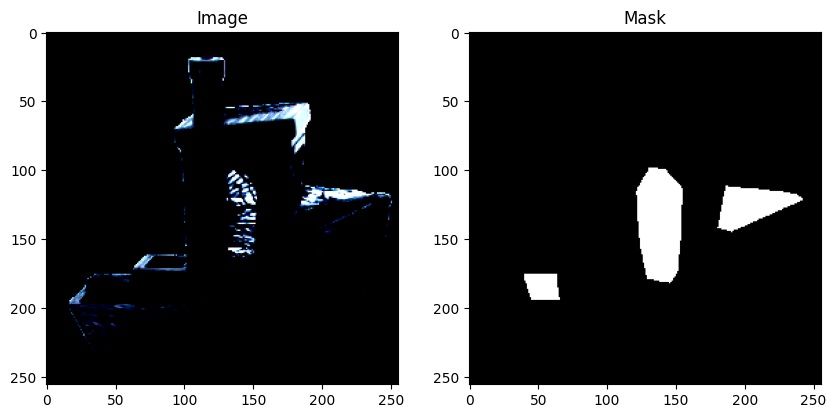

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.img_ids = self.coco.getImgIds()
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info["file_name"])

        # Загружаем изображение
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Загружаем маску
        mask = coco_to_mask(img_id, self.coco)

        # Аугментации
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask

# Аугментации и нормализация
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Создаем dataset и DataLoader
train_dataset = SegmentationDataset(IMAGE_PATH, ANNOTATION_FILE, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Проверяем загруженные данные
image, mask = train_dataset[0]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image.permute(1,2,0))
plt.title("Image")
plt.subplot(1,2,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.show()


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class PSPModule(nn.Module):
    def __init__(self, in_channels, pool_sizes=(1, 2, 3, 6)):
        super(PSPModule, self).__init__()
        self.pool_sizes = pool_sizes
        self.out_channels = in_channels // len(pool_sizes)

        self.pools = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=pool),
                nn.Conv2d(in_channels, self.out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(self.out_channels),
                nn.ReLU(inplace=True)
            ) for pool in pool_sizes
        ])

    def forward(self, x):
        h, w = x.shape[2], x.shape[3]
        pooled_features = [F.interpolate(pool(x), size=(h, w), mode='bilinear', align_corners=True) for pool in self.pools]
        return torch.cat([x] + pooled_features, dim=1)

class PSPNet(nn.Module):
    def __init__(self, num_classes=2, backbone='resnet50'):
        super(PSPNet, self).__init__()

        # Backbone ResNet-50
        resnet = models.resnet50(pretrained=True)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # PSP Module
        self.psp = PSPModule(in_channels=2048)

        # Финальные слои
        self.final_conv = nn.Sequential(
            nn.Conv2d(4096, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.psp(x)
        x = self.final_conv(x)
        x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=True)
        return x


In [ ]:
# Создание модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PSPNet(num_classes=2).to(device)

# Оптимизатор и функция потерь
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Цикл обучения
for epoch in range(100):
    model.train()
    total_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Преобразуем маску: нормализуем значения 255 → 1
        masks = (masks > 0).long()  # Все пиксели > 0 становятся 1

        # Изменяем размер маски до выхода модели (64x64)
        masks_resized = F.interpolate(masks.unsqueeze(1).float(), size=(64, 64), mode='nearest').squeeze(1).long()

        optimizer.zero_grad()
        outputs = model(images)

        # Проверяем, что маска содержит только [0, num_classes-1]
        assert masks_resized.max() < 2, f"Ошибка! Маска содержит значения {masks_resized.unique()}"

        loss = criterion(outputs, masks_resized)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")




/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 76.1MB/s]


Epoch 1, Loss: 0.3230
Epoch 2, Loss: 0.1883
Epoch 3, Loss: 0.1619
Epoch 4, Loss: 0.1442
Epoch 5, Loss: 0.1284
Epoch 6, Loss: 0.1174
Epoch 7, Loss: 0.1132
Epoch 8, Loss: 0.1089
Epoch 9, Loss: 0.1037
Epoch 10, Loss: 0.0988
Epoch 11, Loss: 0.0965
Epoch 12, Loss: 0.0929
Epoch 13, Loss: 0.0892
Epoch 14, Loss: 0.0881
Epoch 15, Loss: 0.0877
Epoch 16, Loss: 0.0855
Epoch 17, Loss: 0.0827
Epoch 18, Loss: 0.0818
Epoch 19, Loss: 0.0804
Epoch 20, Loss: 0.0800
Epoch 21, Loss: 0.0795
Epoch 22, Loss: 0.0783
Epoch 23, Loss: 0.0772
Epoch 24, Loss: 0.0768
Epoch 25, Loss: 0.0782
Epoch 26, Loss: 0.0812
Epoch 27, Loss: 0.0961
Epoch 28, Loss: 0.1212
Epoch 29, Loss: 0.0954
Epoch 30, Loss: 0.0828
Epoch 31, Loss: 0.0764
Epoch 32, Loss: 0.0733
Epoch 33, Loss: 0.0721
Epoch 34, Loss: 0.0715
Epoch 35, Loss: 0.0708
Epoch 36, Loss: 0.0701
Epoch 37, Loss: 0.0700
Epoch 38, Loss: 0.0696
Epoch 39, Loss: 0.0694
Epoch 40, Loss: 0.0691
Epoch 41, Loss: 0.0688
Epoch 42, Loss: 0.0689
Epoch 43, Loss: 0.0687
Epoch 44, Loss: 0.06

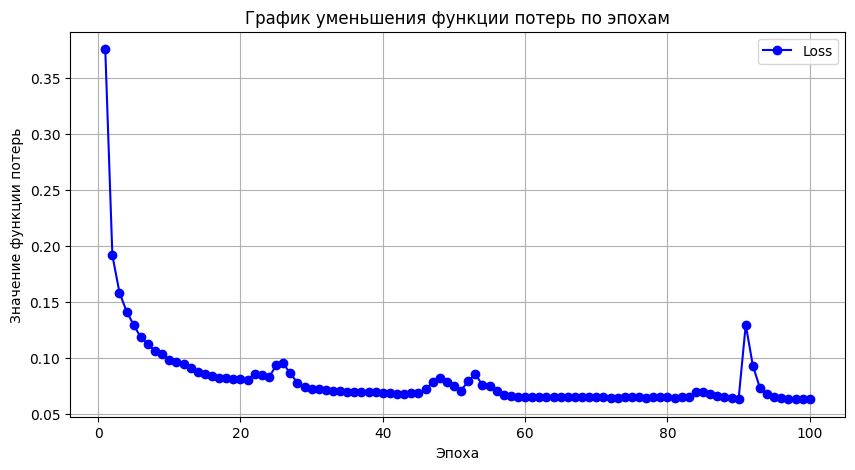

In [ ]:
import matplotlib.pyplot as plt

# Значения функции потерь (Loss) из логов
epochs = list(range(1, 101))  # 100 эпох
loss_values = [
    0.3756, 0.1918, 0.1586, 0.1417, 0.1297, 0.1186, 0.1127, 0.1065, 0.1034, 0.0988,
    0.0970, 0.0952, 0.0915, 0.0882, 0.0864, 0.0844, 0.0828, 0.0820, 0.0819, 0.0817,
    0.0810, 0.0858, 0.0851, 0.0829, 0.0936, 0.0955, 0.0865, 0.0783, 0.0747, 0.0729,
    0.0725, 0.0714, 0.0708, 0.0705, 0.0699, 0.0700, 0.0702, 0.0700, 0.0696, 0.0694,
    0.0692, 0.0686, 0.0686, 0.0688, 0.0690, 0.0722, 0.0786, 0.0828, 0.0787, 0.0749,
    0.0712, 0.0797, 0.0859, 0.0761, 0.0757, 0.0704, 0.0674, 0.0663, 0.0659, 0.0658,
    0.0656, 0.0654, 0.0653, 0.0653, 0.0654, 0.0652, 0.0652, 0.0652, 0.0654, 0.0653,
    0.0652, 0.0650, 0.0648, 0.0651, 0.0652, 0.0652, 0.0650, 0.0652, 0.0653, 0.0651,
    0.0649, 0.0655, 0.0653, 0.0702, 0.0698, 0.0683, 0.0665, 0.0651, 0.0642, 0.0640,
    0.1300, 0.0934, 0.0734, 0.0678, 0.0658, 0.0647, 0.0641, 0.0639, 0.0636, 0.0635
]

# Построение графика функции потерь
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label='Loss')
plt.xlabel("Эпоха")
plt.ylabel("Значение функции потерь")
plt.title("График уменьшения функции потерь по эпохам")
plt.legend()
plt.grid(True)
plt.show()


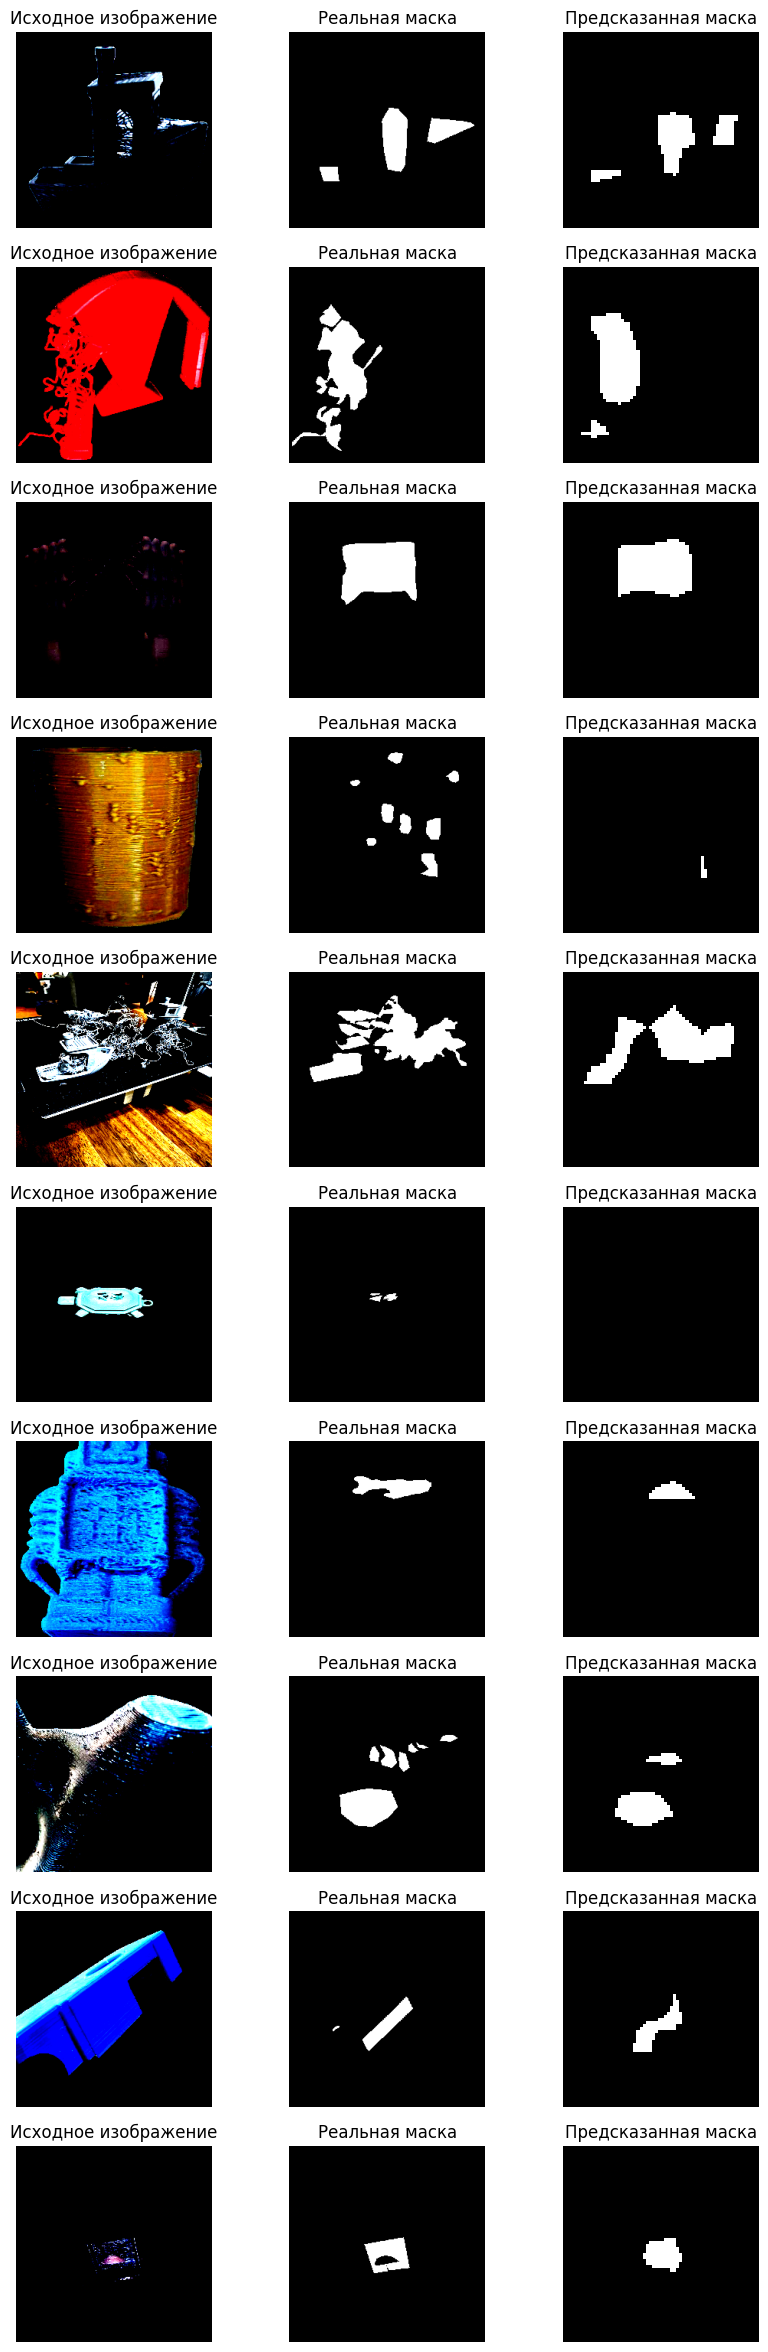

In [ ]:
import torch
import numpy as np

# Включаем режим оценки
model.eval()

# Берем несколько тестовых изображений
num_samples = 10
fig, axs = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

for i in range(num_samples):
    image, mask = train_dataset[i]  # Берем изображение из train_dataset

    # Преобразуем данные для передачи в модель
    image_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Предсказанная маска

    # Отображаем результаты
    axs[i, 0].imshow(image.permute(1,2,0))
    axs[i, 0].set_title("Исходное изображение")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 1].set_title("Реальная маска")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(pred_mask, cmap="gray")
    axs[i, 2].set_title("Предсказанная маска")
    axs[i, 2].axis("off")

plt.show()


In [ ]:
import torch
import numpy as np
import cv2

# Функция для вычисления метрик
def compute_segmentation_metrics(y_pred, y_true, num_classes=2):
    """
    Вычисляет Mean IoU, Dice Score, Pixel Accuracy, F1 Score и mAP для сегментации.
    """
    iou_scores = []
    dice_scores = []
    pixel_accuracies = []
    f1_scores = []
    precisions = []

    # Приводим предсказанную маску к размеру y_true
    y_pred_resized = cv2.resize(y_pred, (y_true.shape[1], y_true.shape[0]), interpolation=cv2.INTER_NEAREST)

    for cls in range(1, num_classes):  # Пропускаем фон (класс 0)
        pred_mask = (y_pred_resized == cls).astype(np.float32)
        true_mask = (y_true == cls).astype(np.float32)

        intersection = (pred_mask * true_mask).sum()
        union = pred_mask.sum() + true_mask.sum() - intersection

        iou = intersection / union if union > 0 else 1.0
        dice = (2. * intersection) / (pred_mask.sum() + true_mask.sum()) if (pred_mask.sum() + true_mask.sum()) > 0 else 1.0

        tp = intersection
        fp = pred_mask.sum() - intersection
        fn = true_mask.sum() - intersection

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        iou_scores.append(iou)
        dice_scores.append(dice)
        f1_scores.append(f1)
        precisions.append(precision)

        # Pixel Accuracy (доля правильно классифицированных пикселей)
        pixel_accuracy = np.mean(y_pred_resized == y_true)
        pixel_accuracies.append(pixel_accuracy)

    # Mean Average Precision (mAP) — среднее значение Precision
    mean_ap = np.mean(precisions)

    return {
        "Mean IoU": np.mean(iou_scores),
        "Mean Dice Coefficient": np.mean(dice_scores),
        "Mean Pixel Accuracy": np.mean(pixel_accuracies),
        "Mean F1 Score": np.mean(f1_scores),
        "Mean Average Precision (mAP)": mean_ap
    }

# Оценка модели на нескольких тестовых изображениях
model.eval()
metrics_list = []

for i in range(1000):  # Тестируем на 10 изображениях
    image, mask = train_dataset[i]
    image_tensor = image.unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        output = model(image_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # Вычисляем метрики
    metrics = compute_segmentation_metrics(pred_mask, mask.numpy(), num_classes=2)
    metrics_list.append(metrics)

# Усредняем метрики по всем тестам
final_metrics = {key: np.mean([m[key] for m in metrics_list]) for key in metrics_list[0]}
final_metrics


{'Mean IoU': 0.1,
 'Mean Dice Coefficient': 0.1,
 'Mean Pixel Accuracy': 0.8866484832763671,
 'Mean F1 Score': 0.0,
 'Mean Average Precision (mAP)': 0.0}